# Machine Learning approach
Siamese Network outputs 512 dims vector. This competition data set is unbalance so try over sampling without image augmentation I chose SMOTE.  
At first get siamese outputs from train dataset with train some epochs. Then train lightGBM and predict by siamese outputs from test dataset.
## BE CAREFUL!
This approach is not work. May be the gap between train dataset outputs and test dataset outputs is big... So my lightGBM model predict const values.  
This note is just for how to use lightGBM (and tuning with optuna), PCA and SMOTE.

In [1]:
!pip install optuna
!pip install lightgbm

In [2]:
!ls ../input/

humpback-whale-identification  p2h-tmp	score-and-etc


In [3]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
from PIL import Image
from os.path import isfile

import lightgbm as lgb
import matplotlib.pyplot as plt #Visulization
import seaborn as sns

from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy.stats

import pickle
import joblib


import matplotlib
% matplotlib inline
plt.style.use('ggplot') 
# font = {'family' : 'meiryo'}
# matplotlib.rc('font', **font)

# Load Data and Normalization
These dump file is (fknown, fsubmit, h2i, train, h2ws, known) from trained results of https://www.kaggle.com/seesee/siamese-pretrained-0-822  
fknown : CNN output of known(train) images  
fsubmit : CNN output of unknown(test) images  
  
Although lightGBM doesn't need normalize data, this kernel create features from some CNN outputs. So normalize may be need.

In [4]:
TRAIN_DF = '../input/humpback-whale-identification/train.csv'
SUB_Df = '../input/humpback-whale-identification/sample_submission.csv'
TRAIN = '../input/humpback-whale-identification/train/'
TEST = '../input/humpback-whale-identification/test/'
P2H = '../input/p2h-tmp/p2h_.pickle'
P2SIZE = '../input/metadata/p2size.pickle'
BB_DF = "../input/metadata/bounding_boxes.csv"

tagged = dict([(p, w) for _, p, w in pd.read_csv(TRAIN_DF).to_records()])
submit = [p for _, p, _ in pd.read_csv(SUB_Df).to_records()]
join = list(tagged.keys()) + submit

dump_path1 = '../input/score-and-etc/standard_250_002_joblib_without_score'
dump_path2 = '../input/score-and-etc/standard_500_010_joblib_without_score'
dump_path3 = '../input/score-and-etc/standard_550_009_joblib_without_score'
dump_path4 = '../input/score-and-etc/standard_600_002_joblib_without_score'

def get_normalized_ndarray(ndarray):
    ndarray_norm = scipy.stats.zscore(ndarray, axis=None)
    ndarray_norm = ndarray_norm / ndarray_norm.max().max()
    return ndarray_norm

if isfile(dump_path1):
    fknown1, fsubmit1, h2i, train, h2ws, known = joblib.load(dump_path1)
    print('load_dump1')

if isfile(dump_path2):
    fknown2, fsubmit2, h2i, train, h2ws, known = joblib.load(dump_path2)
    print('load_dump2')

if isfile(dump_path3):
    fknown3, fsubmit3, h2i, train, h2ws, known = joblib.load(dump_path3)
    print('load_dump3')
    
if isfile(dump_path4):
    fknown4, fsubmit4, h2i, train, h2ws, known = joblib.load(dump_path4)
    print('load_dump4')

if isfile(P2H):
    with open(P2H, 'rb') as f:
        p2h = pickle.load(f)
        print('load p2h')

load_dump1
load_dump2
load_dump3
load_dump4
load p2h


In [5]:
fknown1 = get_normalized_ndarray(fknown1)
fknown2 = get_normalized_ndarray(fknown2)
fknown3 = get_normalized_ndarray(fknown3)
fknown4 = get_normalized_ndarray(fknown4)

In [6]:
def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val]
known_list = [get_keys_from_value(p2h, known_id)[0] for known_id in tqdm(known)]


100%|██████████| 25360/25360 [00:43<00:00, 580.87it/s]


In [7]:
train_df = pd.read_csv(TRAIN_DF)
train_df_has_id = train_df[train_df['Id'] != 'new_whale']

# PCA to down dims
512 dim is too high dims! It's not memory friendly. So, show PCA results and decide how many features I use.  
In this sample, top 60 features can explane almost 80%, so I use 60 features.

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans

# k_cluster_num = 15
# # K-meansによるクラスタリング
# kmeans_model = KMeans(n_clusters=k_cluster_num).fit(new_whales)

# # PCAで次元削減
# pca = PCA(n_components=2)
# new_whales_pca = pca.fit_transform(new_whales)
# print('end clustering')
# cmap = plt.get_cmap("tab10")
# # 結果を散布図にプロット
# plt.figure()
# for (i, label) in enumerate(tqdm(kmeans_model.labels_)):
#     plt.scatter(new_whales_pca[i, 0], new_whales_pca[i, 1], c=cmap(label))
# plt.show()


In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

pca_n_components = 512
pca_all = PCA(n_components=pca_n_components)
X_train_pca_all = pca_all.fit_transform(fknown1)
# pca_all.explained_variance_ratio_

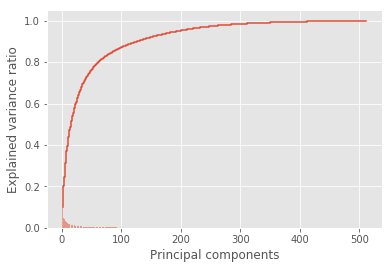

In [10]:
plt.bar(range(1, pca_n_components+1), pca_all.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, pca_n_components+1), np.cumsum(pca_all.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

This plot means PCA's top 60 features can explane 80% of original features.

In [11]:
del pca_all

pca_n_components = 60
pca = PCA(n_components=pca_n_components)
X_train_pca = pca.fit_transform(fknown1)
# pca.explained_variance_ratio_

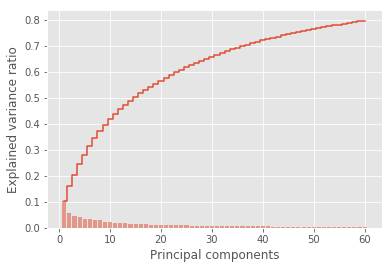

In [12]:
plt.bar(range(1, pca_n_components+1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, pca_n_components+1), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [13]:
def get_trained_df(train_df, pca, fknown):
#     trained_df = trained_df.reset_index(drop=True)
    known_df = pd.DataFrame(pca.fit_transform(fknown))
    known_df['Id'] = train_df['Id']
    known_df['Image'] = train_df['Image']
    return known_df

cols = ['col' + str(i+1) for i in range(pca_n_components)]
cols.append('Id')
cols.append('Image')

known_df1 = get_trained_df(train_df, pca, fknown1)
known_df2 = get_trained_df(train_df, pca, fknown2)
known_df3 = get_trained_df(train_df, pca, fknown3)
known_df4 = get_trained_df(train_df, pca, fknown4)

known_df1.columns = cols
known_df2.columns = cols
known_df3.columns = cols
known_df4.columns = cols

In [14]:
known_df1.shape

(25360, 62)

In [15]:
known_df1.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,col40,col41,col42,col43,col44,col45,col46,col47,col48,col49,col50,col51,col52,col53,col54,col55,col56,col57,col58,col59,col60,Id,Image
0,0.264178,0.048690,-0.537960,0.499906,0.146193,0.407463,0.350210,0.832533,0.052055,-0.205541,0.106128,-0.115668,0.208277,-0.051209,-0.223187,-0.301753,0.211880,0.144791,0.089760,0.119773,0.242235,-0.140746,0.467165,0.124518,-0.042470,-0.130203,-0.026881,0.020031,0.015454,-0.067904,-0.023868,-0.007752,-0.195040,0.026055,-0.254896,0.160157,-0.041942,-0.021629,0.404598,-0.158446,-0.069839,-0.210409,0.103527,-0.193161,0.009214,-0.115216,0.186752,0.067645,0.227502,-0.177140,-0.055795,0.159767,-0.293430,-0.036427,-0.060890,-0.036987,-0.020375,0.118647,-0.044561,-0.142058,w_f48451c,0000e88ab.jpg
1,-0.199571,-1.426987,0.169723,0.114124,-0.412073,0.094038,0.674823,0.017209,-0.092959,0.372340,-0.359052,0.566933,-0.251478,-0.205532,0.119637,-0.213704,0.160937,-0.011838,0.165289,0.179390,-0.169734,-0.187179,-0.110939,-0.134558,-0.076154,0.247997,0.202589,-0.266521,-0.065171,-0.231541,-0.098736,0.217819,-0.123969,0.299738,-0.234580,0.234897,-0.045794,-0.116894,-0.088675,0.014938,-0.117577,-0.162917,0.014832,0.190027,0.305283,0.027758,0.061812,0.186423,-0.183979,-0.192116,-0.026875,-0.055224,0.104182,-0.056677,-0.074762,-0.118298,-0.235894,-0.103579,-0.150372,0.066925,w_c3d896a,0001f9222.jpg
2,1.038216,-0.246276,-0.919789,0.463684,0.288893,-0.123772,0.464163,0.329865,-0.170784,-0.093173,-0.128435,-0.226512,0.325614,-0.339695,-0.085936,-0.242328,0.075520,-0.531590,0.372295,-0.373182,0.134166,0.039174,0.210661,0.070794,-0.248601,0.227369,0.142004,0.368952,-0.013981,0.044457,-0.027122,-0.181148,0.070619,0.039393,-0.372338,-0.389216,0.066688,0.033829,0.233834,-0.042382,-0.246687,0.166488,0.077790,0.142102,-0.206330,-0.002309,-0.036567,0.093173,0.195259,0.235964,-0.116430,0.099615,0.007231,0.122758,-0.006374,-0.170457,0.060859,0.080432,-0.102063,0.031347,w_20df2c5,00029d126.jpg
3,0.314156,-1.070764,0.632649,-0.340697,-0.114739,0.096455,-0.066383,0.634566,-0.266554,0.045849,0.569306,0.124261,0.195613,0.145980,0.089345,-0.484671,-0.016475,0.188178,0.260305,0.033706,0.068497,0.275799,-0.378565,0.009879,0.381855,0.575454,0.292861,-0.334074,-0.103937,-0.064454,0.250320,-0.174823,0.207649,0.159285,-0.096062,-0.133909,0.121387,0.012790,0.334936,-0.165551,-0.164112,0.346852,0.034763,-0.120890,-0.211293,0.177443,0.046560,-0.199754,0.068231,0.027681,0.145851,0.039909,0.045929,-0.233385,0.053391,0.191005,0.145547,-0.031886,0.086489,0.009891,new_whale,00050a15a.jpg
4,0.108835,-0.720869,-0.439259,0.838695,0.007478,0.098606,-0.025203,0.405101,-0.135748,0.217109,0.531329,0.424830,-0.005903,-0.514669,0.245234,-0.049665,-0.223965,-0.205195,0.064255,-0.049121,0.017264,0.162331,-0.045662,0.274439,0.086460,0.366472,0.333124,-0.313546,-0.003285,-0.022936,0.077142,0.083864,-0.168837,0.096011,-0.098746,0.031785,0.113177,-0.127011,0.052931,-0.052589,0.126258,-0.126998,-0.077997,-0.073441,0.072170,0.078832,0.017080,0.280986,-0.045867,-0.008316,0.155653,0.047897,-0.050714,-0.010041,0.098251,-0.181078,0.003836,-0.041023,-0.334156,-0.071102,new_whale,0005c1ef8.jpg


# UnderSampling and OverSampling
The next cell checks each id has how many images. We know this data set is unblance data. I think balanced data give us more good result. So drop data which class has too much images and create data which data has only a little images. You can use SMOTE from imblearn library.

In [16]:
# id_df = pd.DataFrame(train_df[train_df['Id'] != 'new_whale']['Id'].value_counts())
id_df = pd.DataFrame(train_df['Id'].value_counts())
id_df = id_df.reset_index()
id_df.columns = ['Id', 'count']
id_df.head()

,Id,count
0,new_whale,9664
1,w_23a388d,73
2,w_9b5109b,65
3,w_9c506f6,62
4,w_0369a5c,61


In [17]:
class_cnt = 10
known_df1_down = pd.DataFrame(columns=cols)
known_df2_down = pd.DataFrame(columns=cols)
known_df3_down = pd.DataFrame(columns=cols)
known_df4_down = pd.DataFrame(columns=cols)

for class_id in tqdm(id_df[id_df['count'] > class_cnt]['Id'].tolist()):
    known_df1_down = pd.concat([known_df1_down, known_df1[known_df1['Id'] == class_id].sample(class_cnt, random_state=84*1)])
    known_df2_down = pd.concat([known_df2_down, known_df2[known_df2['Id'] == class_id].sample(class_cnt, random_state=84*2)])
    known_df3_down = pd.concat([known_df3_down, known_df3[known_df3['Id'] == class_id].sample(class_cnt, random_state=84*3)])
    known_df4_down = pd.concat([known_df4_down, known_df4[known_df4['Id'] == class_id].sample(class_cnt, random_state=84*4)])
    
known_df1_down = pd.concat([known_df1_down, known_df1[known_df1['Id'].isin(id_df[id_df['count'] <= class_cnt]['Id'].tolist())]]).reset_index(drop=True)
known_df2_down = pd.concat([known_df2_down, known_df2[known_df2['Id'].isin(id_df[id_df['count'] <= class_cnt]['Id'].tolist())]]).reset_index(drop=True)
known_df3_down = pd.concat([known_df3_down, known_df3[known_df3['Id'].isin(id_df[id_df['count'] <= class_cnt]['Id'].tolist())]]).reset_index(drop=True)
known_df4_down = pd.concat([known_df4_down, known_df4[known_df4['Id'].isin(id_df[id_df['count'] <= class_cnt]['Id'].tolist())]]).reset_index(drop=True)

100%|██████████| 228/228 [00:03<00:00, 66.65it/s]


In [18]:
known_df1_down.shape

(13623, 62)

In [19]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

df = pd.concat([known_df1_down, known_df2_down, known_df3_down, known_df4_down]).reset_index(drop=True)
X_train = df.drop(['Id', 'Image'], axis=1).values
X_train = scipy.stats.zscore(X_train, axis=None)

# profession = df['Id'].values
# profession_enc = preprocessing.LabelEncoder().fit_transform(profession).reshape(-1,1)
# y_train = OneHotEncoder().fit_transform(profession_enc).toarray()
# print(profession_enc[:15])
# print(y_train[:15].shape)
y_train = df['Id'].tolist()

In [20]:
%%time
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=84, k_neighbors=1)
X_res, y_res = sm.fit_sample(X_train, y_train)

Using TensorFlow backend.


CPU times: user 1min 26s, sys: 51.3 s, total: 2min 17s
Wall time: 2min 18s


In [21]:
def shuffle_samples(X, y):
    zipped = list(zip(X, y))
    np.random.shuffle(zipped)
    X_result, y_result = zip(*zipped)
    return np.asarray(X_result), np.asarray(y_result)

X_res, y_res = shuffle_samples(X_res, y_res)

In [22]:
X_res.shape

(200200, 60)

In [23]:
encoder = preprocessing.LabelEncoder()
y_res = encoder.fit_transform(y_res).reshape(-1,1)

In [24]:
y_res = [label[0] for label in y_res]
y_res = np.array(y_res)

By the way, this kernel has a lot of val and they use memory a lot! (I know this code is dirty but when I write this code I don't have enough time)  
So let's drop needless vals

In [25]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                    X_res|  48048112|
|                  X_train|  13078192|
|                       df|  22668776|
|                  fknown1|  51937392|
|                  fknown2|  51937392|
|                  fknown3|  51937392|
|                  fknown4|  51937392|
|                 fsubmit1|  16302192|
|                 fsubmit2|  16302192|
|                 fsubmit3|  16302192|
|                 fsubmit4|  16302192|
|                      h2i|   1310816|
|                     h2ws|   1310816|
|                    id_df|    570674|
|                     join|    266632|
|                    known|    225112|
|                known_df1|  10549864|
|           known_df1_down|   5667272|
|                known_df2|  10549864|
|           known_df2_down|   5667272|
|                known_df3|  10549864|
|           known_df3_down|   5667272|
|                known_df4|  10549864|
|           known_df4_dow

In [26]:
del known_df1_down, known_df2_down, known_df3_down, known_df4_down
del known_df1, known_df2, known_df3, known_df4
del X_train_pca_all, X_train_pca, X_train, y_train, plt
del fknown1, fknown2, fknown3, fknown4, fsubmit1, fsubmit2, fsubmit3, fsubmit4
del df, train_df, train_df_has_id
del h2i, h2ws, join, known, p2h, submit, tagged, train, known_list, id_df

In [27]:
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                    X_res|  48048112|
|                    y_res|   1601696|


## Param tuning
The next cell written the way of tuning lightGBM with Optuna. If you want to tune up hyper-params, please remove #s (not all just first one).  
But it takes a lot of time so may you can't exec all trial on kernel... 

In [28]:
import lightgbm as lgb
import optuna, os, uuid, pickle
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import shutil
import time

# def train_optuna(X, y):
#     start_time = time.time()
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=84)

#     def objectives(trial):
#         # 試行にUUIDを設定
#         trial_uuid = str(uuid.uuid4())
#         trial.set_user_attr("uuid", trial_uuid)

#         params = {
#             'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
#             'objective': 'multiclass',
#             'num_class': 5005,
#             'metric': {'multi_logloss', 'multi_error'},#, 'auc'},
#             'num_leaves': trial.suggest_int("num_leaves", 10, 68),
#             'learning_rate': trial.suggest_loguniform("learning_rate", 6e-4, 9e-3),
# #             'feature_fraction': trial.suggest_uniform("feature_fraction", 0.0, 1.0),
#             'feature_fraction': trial.suggest_uniform("feature_fraction", 0.3, 0.7),

#             #'device' : 'gpu',
#             'verbose' : 0
#         }
#         if params['boosting_type'] == 'dart':
#             params['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-8, 1.0)
#             params['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
#         if params['boosting_type'] == 'goss':
#             params['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
#             params['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - params['top_rate'])

#         print('uuid is : ' + str(trial_uuid))
#         print('param is ...')
#         print(params)
#         # 枝刈りありの訓練
#         pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "multi_logloss")
#         gbm = lgb.train(params, lgb.Dataset(X_train, y_train), num_boost_round=15,
#                         valid_sets=lgb.Dataset(X_test, y_test), callbacks=[pruning_callback],
#                         early_stopping_rounds=5, )#categorical_feature=['size_info'])

#         # 訓練、テスト誤差
#         y_pred_train = np.rint(gbm.predict(X_train))
#         y_pred_test = np.rint(gbm.predict(X_test))
#         error_train = 1.0 - accuracy_score(y_train, y_pred_train)
#         error_test = 1.0 - accuracy_score(y_test, y_pred_test)

#         # エラー率の記録
#         trial.set_user_attr("train_error", error_train)
#         trial.set_user_attr("test_error", error_test)

#         # モデルの保存
#         if not os.path.exists("lgb_output"):
#             os.mkdir("lgb_output")
#         with open("lgb_output/"+f"{trial_uuid}.pkl", "wb") as fp:
#             pickle.dump(gbm, fp)

# #         process_time = time.time() - start_time
# #         print(str(process_time - start_time))
# #         print('*********************************************************************')
# #         print(trial_uuid)
# #         print('error_train : ' + str(error_train))
# #         print('error_test : ' + str(error_test))
# #         print('*********************************************************************')
#         return error_test

#     study = optuna.create_study()
#     # SQLiteに記録する場合は、ディスクアクセスが遅いとボトルネックになることもある
#     #study = optuna.create_study(storage="sqlite:///brestcancer_lgb.db", study_name="brestcancer_lgb")
#     study.optimize(objectives, n_trials=500)

# #     print(study.best_params)
# #     print(study.best_value)

#     # best_paramsにはuser_attrは表示されないのでtrialから呼ぶ（dict形式で記録されている）
#     print(study.best_trial.user_attrs)

#     df = study.trials_dataframe()
#     output_csv = 'optuna_lgb.csv'
# #     df.to_csv(output_csv)
# #     shutil.copyfile(output_csv, '/content/drive/My Drive/share/kaggle/competition/HumpbackWhaleIdentification/result/' + output_csv)
    
#     return study.best_trial.user_attrs
    
# result_dict = train_optuna(X_res, y_res)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.10, random_state=84)
del X_res, y_res

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 5005,
    'metric': ['multi_error'],
    'num_leaves': 45,
    'learning_rate': 0.002097358935704443,
    'feature_fraction': 0.6696988478476772,
    'verbose' : 0
}

gbm = lgb.train(params, lgb.Dataset(X_train, y_train), num_boost_round=5,
                        valid_sets=lgb.Dataset(X_test, y_test),# callbacks=['maluti_error'],
                        early_stopping_rounds=5, 
               )

[1]	valid_0's multi_error: 0.377722
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_error: 0.313886
[3]	valid_0's multi_error: 0.28047
[4]	valid_0's multi_error: 0.258891
[5]	valid_0's multi_error: 0.244905
Did not meet early stopping. Best iteration is:
[5]	valid_0's multi_error: 0.244905


In [30]:
del X_train, X_test, y_train, y_test
dump_data = (gbm, params)
joblib.dump(dump_data, 'gbm_joblib', compress=3)

['gbm_joblib']

In [31]:
!ls ../

config	input  lib  working


In [32]:
if isfile(dump_path1):
    _, fsubmit1, _, _, _, _ = joblib.load(dump_path1)
    print('load_dump1')

if isfile(dump_path2):
    _, fsubmit2, _, _, _, _ = joblib.load(dump_path2)
    print('load_dump2')

if isfile(dump_path3):
    _, fsubmit3, _, _, _, _ = joblib.load(dump_path3)
    print('load_dump3')
    
if isfile(dump_path4):
    _, fsubmit4, _, _, _, _ = joblib.load(dump_path4)
    print('load_dump4')

load_dump1
load_dump2
load_dump3
load_dump4


In [33]:
fsubmit1 = get_normalized_ndarray(fsubmit1)
fsubmit2 = get_normalized_ndarray(fsubmit2)
fsubmit3 = get_normalized_ndarray(fsubmit3)
fsubmit4 = get_normalized_ndarray(fsubmit4)

# fsubmit = (fsubmit1 + fsubmit2 + fsubmit3 + fsubmit4) / 4
# fsubmit_pca = pca.fit_transform(fsubmit)
# del fsubmit1, fsubmit2, fsubmit3, fsubmit4, fsubmit

In [34]:
pd.DataFrame(fsubmit1).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,-0.041448,0.039563,0.031313,-0.125862,0.156537,0.069167,0.013188,0.070626,0.141855,0.099244,0.279611,0.366561,-0.030291,0.064520,0.009478,-0.070318,0.018719,0.252980,0.001314,0.013690,0.041215,0.042299,-0.011070,-0.049598,0.182050,-0.132604,-0.039935,-0.018837,-0.011302,-0.019000,-0.040572,-0.064005,0.030874,-0.050336,0.028019,-0.108074,-0.045819,-0.036650,-0.200641,0.045791,...,0.181543,0.200204,0.156890,0.276725,-0.115655,-0.041277,-0.020929,-0.028976,-0.066142,0.308758,0.109737,0.013705,-0.091887,-0.000303,0.040283,0.089873,-0.060350,-0.123852,-0.016194,0.006701,0.095896,0.006138,0.004298,0.218761,-0.108507,-0.038708,-0.146146,0.020920,-0.022856,-0.064708,0.068730,0.029265,0.010050,0.021066,0.179763,-0.047324,0.028580,0.017945,0.017040,-0.001159
1,-0.186363,0.005513,0.015065,-0.160529,0.107293,0.087916,0.166024,-0.091205,0.183975,0.091594,-0.037403,0.322657,-0.045940,0.232657,-0.185875,-0.096646,0.010483,0.115613,0.010905,-0.001582,0.141396,0.010848,0.261355,-0.082450,0.258855,-0.108479,-0.010075,0.021705,0.022034,0.018031,-0.048034,-0.117335,0.112809,0.110679,-0.031146,-0.202105,-0.078482,0.017152,-0.090558,-0.048266,...,0.077174,0.099129,0.036000,-0.157822,0.189255,-0.078594,-0.009831,0.125276,-0.028582,-0.063496,0.175293,0.341070,-0.063057,0.161053,-0.186251,0.035643,-0.076369,-0.108206,0.018520,-0.010608,0.046767,0.026661,0.002871,-0.029099,-0.124872,-0.033812,0.043412,-0.159707,0.056864,0.021470,0.076142,-0.071549,0.016120,-0.027957,0.196163,-0.042117,-0.031101,0.036234,-0.015708,-0.031111
2,0.252103,-0.058781,-0.002607,-0.082308,0.028790,0.091574,0.114433,-0.089985,0.106531,0.015792,0.313243,-0.208075,-0.052955,0.358097,-0.206972,-0.059865,0.025922,0.297001,0.014452,0.025113,-0.128335,0.024750,0.105029,-0.046703,-0.035053,-0.091321,0.016225,-0.070021,-0.083525,0.021088,0.009554,-0.080225,-0.009637,0.090299,-0.064082,0.201585,-0.066384,0.053686,-0.010716,-0.042882,...,0.161470,0.108622,0.136361,0.017660,-0.095385,-0.035321,0.018181,0.043948,-0.006928,0.303396,0.042096,-0.039680,0.196750,0.127964,-0.144400,0.094458,-0.078200,-0.123471,0.093241,0.008894,0.097985,-0.025100,0.023103,0.191150,-0.003026,-0.029775,-0.008836,-0.145473,0.191993,0.108420,0.078638,-0.108881,-0.013141,0.088205,0.148569,-0.080073,-0.053219,0.032890,-0.064301,0.014210
3,-0.121336,-0.006178,0.038886,-0.114080,0.014270,0.002616,0.098305,0.032510,-0.077315,0.014797,-0.006729,0.097956,-0.006854,-0.012087,-0.053828,-0.021618,-0.033396,-0.063354,-0.076698,0.041540,0.084740,-0.073502,-0.154080,-0.036082,-0.132946,-0.052680,-0.057208,-0.027696,0.087330,-0.016053,-0.068265,-0.096991,-0.041679,-0.034233,-0.085390,0.160511,0.036455,0.027004,-0.066921,-0.074650,...,0.420448,-0.074758,0.060884,-0.026658,-0.000882,-0.086700,0.068755,-0.088188,0.005754,-0.083329,0.077286,0.278744,-0.106108,0.243120,0.097137,0.140377,-0.016914,-0.146498,0.081810,0.028615,0.013707,0.030578,-0.017801,-0.172874,0.274187,0.100285,-0.026547,0.070958,-0.106708,-0.045579,0.061246,-0.056653,0.031352,0.019351,0.037392,-0.078950,0.070972,0.008400,-0.032435,-0.014950
4,0.040922,0.013810,0.029544,-0.147280,-0.101406,0.152857,-0.032904,0.118519,0.061193,-0.011864,-0.113313,-0.214911,-0.038500,0.133813,-0.152216,-0.059635,0.013061,-0.036068,-0.048615,-0.039259,0.008313,0.033965,-0.202626,-0.047108,-0.064787,-0.079189,-0.076913,-0.078856,0.063424,-0.034147,-0.104270,-0.070951,0.016487,-0.083035,-0.023256,0.103354,-0.041095,0.030474,0.137474,-0.159547,...,-0.066096,0.056895,0.020328,-0.211809,-0.058497,-0.157461,0.152163,0.075382,-0.072389,0.054925,0.067439,0.299679,0.243040,-0.002427,-0.014125,0.130144,-0.053600,-0.164761,0.042225,-0.023698,-0.083424,0.012943,-0.099498,0.219841,0.096329,0.059742,0.207715,0.011148,-0.025782,-

In [35]:
def get_pred(fsubmit):
    fsubmit_pca = pca.fit_transform(fsubmit)
    y_pred = gbm.predict(fsubmit_pca, num_iteration=gbm.best_iteration)
    return y_pred

In [36]:
fsubmit_list = [fsubmit1, fsubmit2, fsubmit3, fsubmit4]
fsubmit_list_len = len(fsubmit_list)
y_pred = 0
for fsubmit in tqdm(fsubmit_list):
    tmp_pred = get_pred(fsubmit)
    print('tmp_pred : ' + str(tmp_pred))
    y_pred = y_pred + tmp_pred
    print('y_pred : ' + str(y_pred))
    del fsubmit
y_pred = y_pred / fsubmit_list_len

dump_data = (gbm, params, y_pred)
joblib.dump(dump_data, 'gbm_joblib_with_pred', compress=3)

  0%|          | 0/4 [00:00<?, ?it/s]

tmp_pred : [[0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 ...
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]]
y_pred : [[0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 ...
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]]


 25%|██▌       | 1/4 [00:19<00:58, 19.53s/it]

tmp_pred : [[0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.00019979 0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 ...
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.00019979 0.00018869]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.00019979 0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]]
y_pred : [[0.00041127 0.00042179 0.00043289 ... 0.00042179 0.00039959 0.00037739]
 [0.00041127 0.00042179 0.00043289 ... 0.00042179 0.00039959 0.00037739]
 [0.00041127 0.00042179 0.00043289 ... 0.00042179 0.00039959 0.00037739]
 ...
 [0.00041127 0.00042179 0.00043289 ... 0.00042179 0.00039959 0.00037739]
 [0.00041127 0.00042179 0.00043289 ... 0.00042179 0.00039959 0.00037739]
 [0.00041127 0.00042179 0.00043289 ... 0.00042179 0.00039959 0.00037739]]


 50%|█████     | 2/4 [00:38<00:38, 19.45s/it]

tmp_pred : [[0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.00019979 0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.00019979 0.0001887 ]
 ...
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.00019979 0.00018869]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]]
y_pred : [[0.00061691 0.00063268 0.00064933 ... 0.00063268 0.00059939 0.00056609]
 [0.00061691 0.00063268 0.00064933 ... 0.00063268 0.00059938 0.00056609]
 [0.00061691 0.00063268 0.00064933 ... 0.00063268 0.00059938 0.00056609]
 ...
 [0.00061691 0.00063268 0.00064933 ... 0.00063268 0.00059938 0.00056609]
 [0.00061691 0.00063268 0.00064933 ... 0.00063268 0.00059939 0.00056609]
 [0.00061691 0.00063268 0.00064933 ... 0.00063268 0.00059939 0.00056609]]


 75%|███████▌  | 3/4 [00:58<00:19, 19.47s/it]

tmp_pred : [[0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 ...
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.00019979 0.0001887 ]
 [0.00020564 0.00021089 0.00021644 ... 0.00021089 0.0001998  0.0001887 ]]
y_pred : [[0.00082254 0.00084358 0.00086578 ... 0.00084358 0.00079918 0.00075478]
 [0.00082254 0.00084358 0.00086578 ... 0.00084358 0.00079918 0.00075478]
 [0.00082254 0.00084358 0.00086578 ... 0.00084358 0.00079918 0.00075478]
 ...
 [0.00082254 0.00084358 0.00086578 ... 0.00084358 0.00079918 0.00075478]
 [0.00082254 0.00084358 0.00086578 ... 0.00084358 0.00079918 0.00075478]
 [0.00082254 0.00084358 0.00086578 ... 0.00084358 0.00079918 0.00075478]]


100%|██████████| 4/4 [01:17<00:00, 19.32s/it]


['gbm_joblib_with_pred']

In [37]:
# # y_pred = gbm.predict(fsubmit_pca, num_iteration=gbm.best_iteration)
# # del fsubmit_pca
# K = 5

# # ソートはされていない上位k件のインデックス
# unsorted_max_indices = np.argpartition(-y_pred, K)[:K]
# # 上位k件の値
# y = y_pred[unsorted_max_indices]

# # 大きい順にソートし、インデックスを取得
# indices = np.argsort(-y)

# # 類似度上位k件のインデックス
# max_k_indices = unsorted_max_indices[indices]


In [38]:
y_pred.shape

(7960, 5005)

In [39]:
y_pred.max()

0.0002520181232695243

In [40]:
pred_df = pd.DataFrame(y_pred)
pred_df.head(15)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000,5001,5002,5003,5004
0,0.000206,0.000211,0.000216,0.000205,0.0002,0.0002,0.000189,0.000189,0.000183,0.000205,0.000194,0.0002,0.000211,0.000189,0.000183,0.000205,0.000205,0.000211,0.000189,0.000194,0.000205,0.000211,0.000205,0.000189,0.000205,0.000194,0.000211,0.000194,0.000189,0.000205,0.000189,0.0002,0.0002,0.000205,0.000205,0.0002,0.000205,0.000216,0.000178,0.0002,...,0.000205,0.000205,0.000205,0.000183,0.000194,0.000189,0.000205,0.000211,0.000183,0.000211,0.0002,0.0002,0.000205,0.000189,0.000183,0.000211,0.000178,0.000205,0.000211,0.000205,0.0002,0.000194,0.000183,0.000216,0.000211,0.000189,0.000205,0.000194,0.0002,0.0002,0.000205,0.0002,0.000211,0.0002,0.000183,0.000194,0.000178,0.000211,0.0002,0.000189
1,0.000206,0.000211,0.000216,0.000205,0.0002,0.0002,0.000189,0.000189,0.000183,0.000205,0.000194,0.0002,0.000211,0.000189,0.000183,0.000205,0.000205,0.000211,0.000189,0.000194,0.000205,0.000211,0.000205,0.000189,0.000205,0.000194,0.000211,0.000194,0.000189,0.000205,0.000189,0.0002,0.0002,0.000205,0.000205,0.0002,0.000205,0.000216,0.000178,0.0002,...,0.000205,0.000205,0.000205,0.000183,0.000194,0.000189,0.000205,0.000211,0.000183,0.000211,0.0002,0.0002,0.000205,0.000189,0.000183,0.000211,0.000178,0.000205,0.000211,0.000205,0.0002,0.000194,0.000183,0.000216,0.000211,0.000189,0.000205,0.000194,0.0002,0.0002,0.000205,0.0002,0.000211,0.0002,0.000183,0.000194,0.000178,0.000211,0.0002,0.000189
2,0.000206,0.000211,0.000216,0.000205,0.0002,0.0002,0.000189,0.000189,0.000183,0.000205,0.000194,0.0002,0.000211,0.000189,0.000183,0.000205,0.000205,0.000211,0.000189,0.000194,0.000205,0.000211,0.000205,0.000189,0.000205,0.000194,0.000211,0.000194,0.000189,0.000205,0.000189,0.0002,0.0002,0.000205,0.000205,0.0002,0.000205,0.000216,0.000178,0.0002,...,0.000205,0.000205,0.000205,0.000183,0.000194,0.000189,0.000205,0.000211,0.000183,0.000211,0.0002,0.0002,0.000205,0.000189,0.000183,0.000211,0.000178,0.000205,0.000211,0.000205,0.0002,0.000194,0.000183,0.000216,0.000211,0.000189,0.000205,0.000194,0.0002,0.0002,0.000205,0.0002,0.000211,0.0002,0.000183,0.000194,0.000178,0.000211,0.0002,0.000189
3,0.000206,0.000211,0.000216,0.000205,0.0002,0.0002,0.000189,0.000189,0.000183,0.000205,0.000194,0.0002,0.000211,0.000189,0.000183,0.000205,0.000205,0.000211,0.000189,0.000194,0.000205,0.000211,0.000205,0.000189,0.000205,0.000194,0.000211,0.000194,0.000189,0.000205,0.000189,0.0002,0.0002,0.000205,0.000205,0.0002,0.000205,0.000216,0.000178,0.0002,...,0.000205,0.000205,0.000205,0.000183,0.000194,0.000189,0.000205,0.000211,0.000183,0.000211,0.0002,0.0002,0.000205,0.000189,0.000183,0.000211,0.000178,0.000205,0.000211,0.000205,0.0002,0.000194,0.000183,0.000216,0.000211,0.000189,0.000205,0.000194,0.0002,0.0002,0.000205,0.0002,0.000211,0.0002,0.000183,0.000194,0.000178,0.000211,0.0002,0.000189
4,0.000206,0.000211,0.000216,0.000205,0.0002,0.0002,0.000189,0.000189,0.000183,0.000205,0.000194,0.0002,0.000211,0.000189,0.000183,0.000205,0.000205,0.000211,0.000189,0.000194,0.000205,0.000211,0.000205,0.000189,0.000205,0.000194,0.000211,0.000194,0.000189,0.000205,0.000189,0.0002,0.0002,0.000205,0.000205,0.0002,0.000205,0.000216,0.000178,0.0002,...,0.000205,0.000205,0.000205,0.000183,0.000194,0.000189,0.000205,0.000211,0.000183,0.000211,0.0002,0.0002,0.000205,0.000189,0.000183,0.000211,0.000178,0.000205,0.000211,0.000205,0.0002,0.000194,0.000183,0.000216,0.000211,0.000189,0.000205,0.000194,0.0002,0.0002,0.000205,0.0002,0.000211,0.0002,0.000183,0.000194,0.000178,0.000211,0.0002,0.000189
5,0.000206,0.000211,0.000216,0.000205,0.0002,0.0002,0.000189,0.000189,0.000183,0.000205,0.000194,0.0002,0.000211,0.000189,0.000183,0.000205,0.000205,0.000211,0.000189,0.000194,0.000205,0.000211,0.000205,0.